<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import numpy as np
import random

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'

In [23]:
img_width, img_height = 224, 224
nb_train_samples = 560
nb_validation_samples = 140
epochs = 30
batch_size = 16
noise_factor = 1

In [5]:
def add_noise(img):
    '''Add gaussian noise to images'''
    #VARIABILITY = 50
    #deviation = VARIABILITY*random.random()
    noise_factor=0.5
    noise = noise_factor * np.random.normal(0, 255., img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:
def tuple_generator(generator):
    for batch in generator:
        yield (batch, batch)

In [24]:
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        noise = noise_factor * np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [25]:
#Clean data
train_datagen = ImageDataGenerator(rescale=1. / 255)

val_datagen = ImageDataGenerator(rescale=1. / 255,) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='input') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='input')

#Adding noise
train_noisy = noisy_generator(train_generator)
val_noisy = noisy_generator(validation_generator)

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [26]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

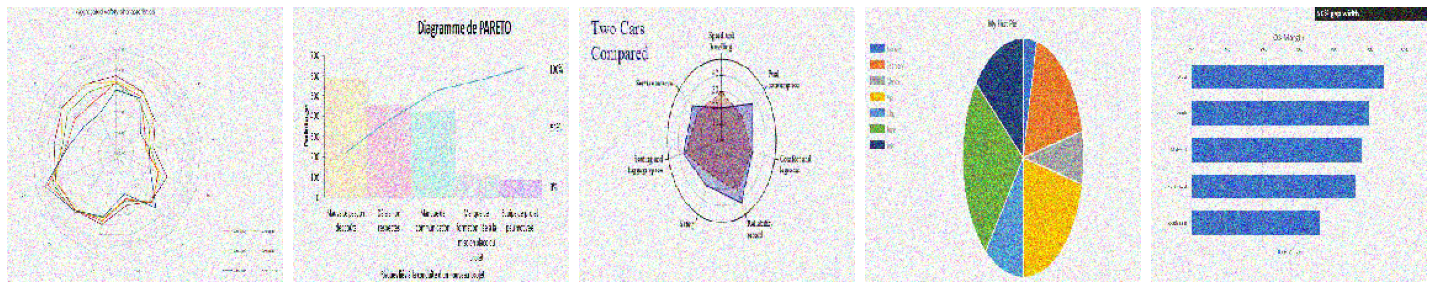

In [27]:
sample_training_images, _ = next(train_noisy)
plotImages(sample_training_images[:5])

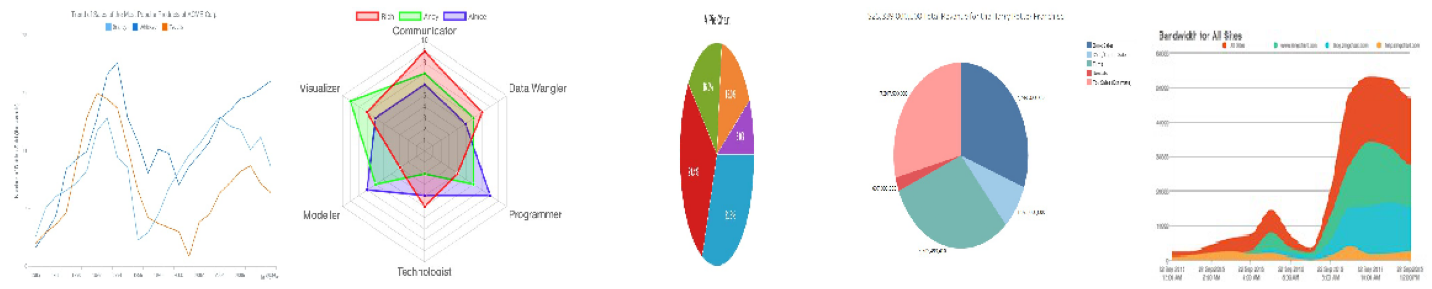

In [28]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

In [29]:
input_img = Input(shape=(img_width, img_height, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
autoencoder.fit(train_noisy, 
                epochs=epochs,
                steps_per_epoch = nb_train_samples // batch_size,
                verbose=1,
                validation_steps = nb_validation_samples // batch_size,
                validation_data= val_noisy)

Epoch 1/30
35/35 [==============================] - 13s 370ms/step - loss: 3.2359e-07 - accuracy: 0.6281 - val_loss: 3.2043e-07 - val_accuracy: 0.6074
Epoch 2/30
35/35 [==============================] - 13s 367ms/step - loss: 3.2465e-07 - accuracy: 0.6207 - val_loss: 3.1661e-07 - val_accuracy: 0.5892
Epoch 3/30
35/35 [==============================] - 13s 368ms/step - loss: 3.2456e-07 - accuracy: 0.6225 - val_loss: 3.2232e-07 - val_accuracy: 0.6339
Epoch 4/30
35/35 [==============================] - 13s 372ms/step - loss: 3.2363e-07 - accuracy: 0.6241 - val_loss: 3.2090e-07 - val_accuracy: 0.6118
Epoch 5/30
35/35 [==============================] - 13s 377ms/step - loss: 3.2446e-07 - accuracy: 0.6244 - val_loss: 3.1991e-07 - val_accuracy: 0.6000
Epoch 6/30
35/35 [==============================] - 13s 372ms/step - loss: 3.2381e-07 - accuracy: 0.6171 - val_loss: 3.2023e-07 - val_accuracy: 0.6186
Epoch 7/30
35/35 [==============================] - 13s 358ms/step - loss: 3.2344e-07 - accura

In [42]:
X, y = next(val_noisy)

In [43]:
X = X[:1]
decode_img = autoencoder.predict([X])


ValueError: ignored

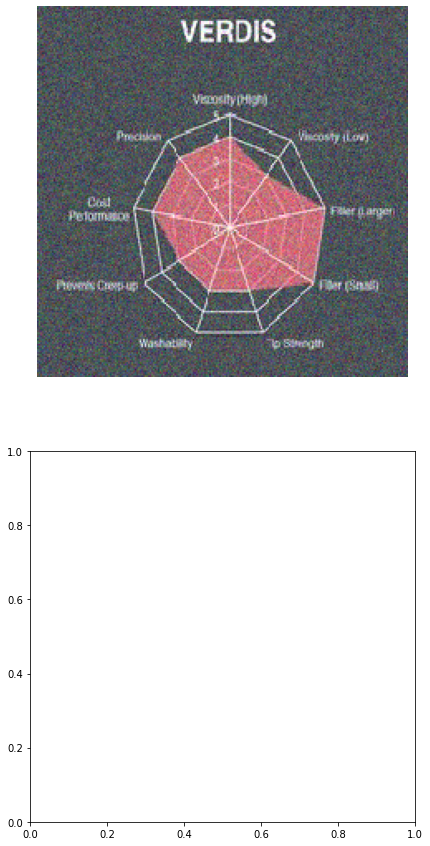

In [40]:
import matplotlib.pyplot as plt
import tensorflow as tf


n = 5

plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X[i])
    ax.axis('off')

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decode_img[i].reshape((224,224,3)) )
    ax.axis('off')

plt.show()

TypeError: ignored

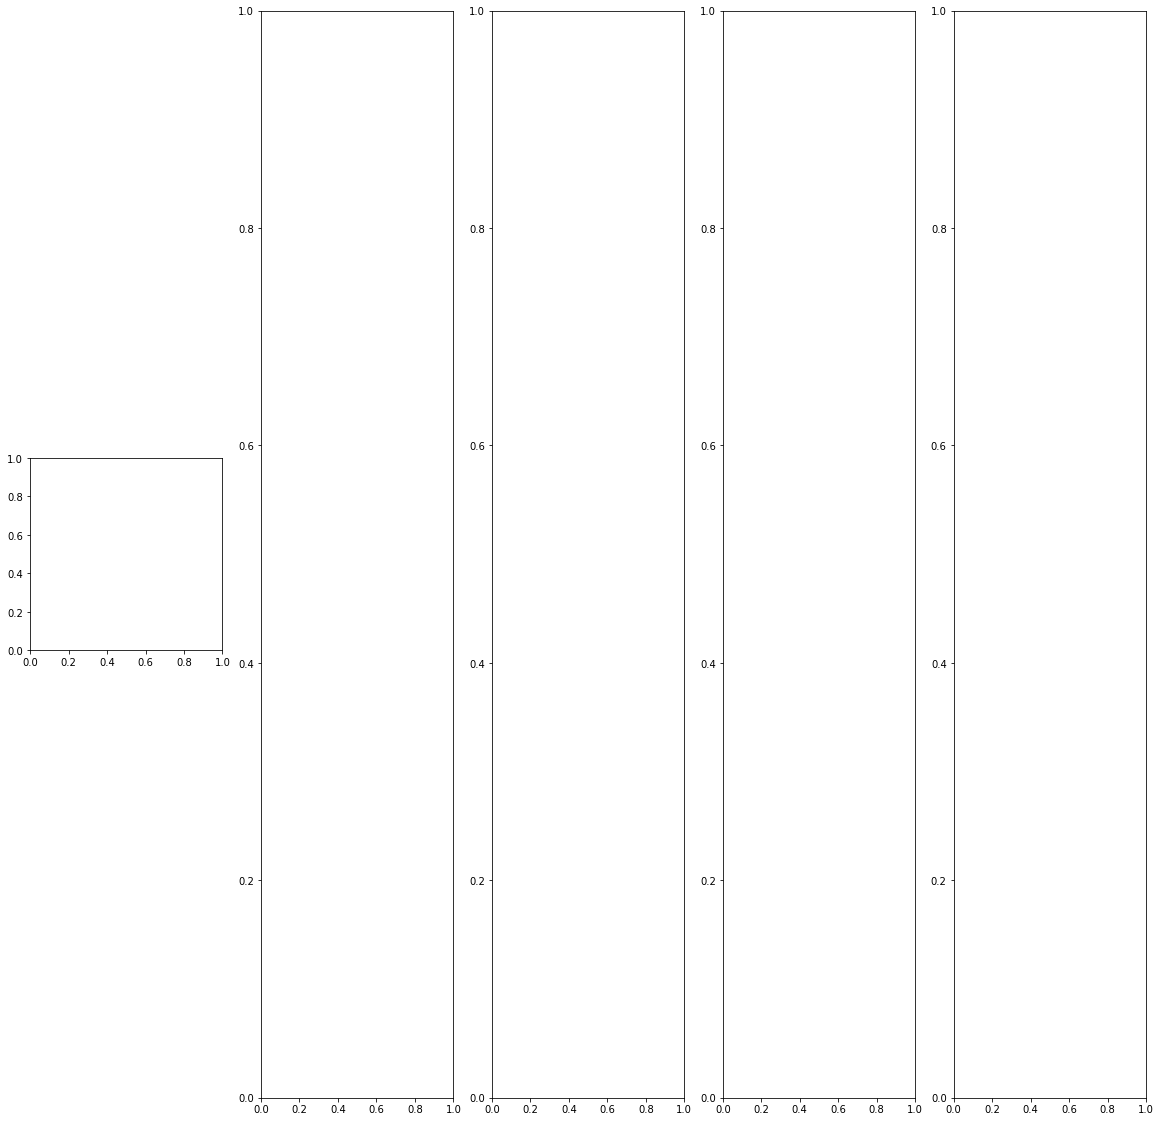

In [36]:
plotImages(decode_img[:5])

ValueError: ignored

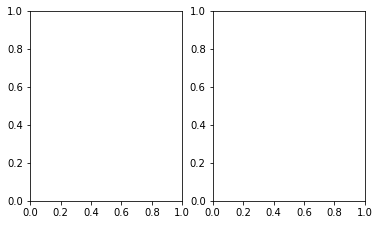

In [44]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(6, 3.5)
X_reshaped = X.reshape((img_width, img_height))
image_reshaped = decode_img.reshape((img_width, img_height))
axes[0].imshow(X_reshaped) 
axes[0].set_title('Original image')
axes[1].imshow(image_reshaped)
axes[1].set_title('Reconstruction')
plt.show()